In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_ROOT = "/content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped_segpre"

train_dir = f"{DATA_ROOT}/train"
val_dir   = f"{DATA_ROOT}/valid"
test_dir  = f"{DATA_ROOT}/test"

In [ ]:
import glob
from torch.utils.data import Dataset
from PIL import Image
import os

class TongueDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform

        self.samples = []
        classes = sorted(d for d in os.listdir(root)
                         if os.path.isdir(os.path.join(root, d)))
        self.class_to_idx = {c: i for i, c in enumerate(classes)}
        self.classes = classes

        for cls in classes:
            cls_dir = os.path.join(root, cls)
            for ext in ("*.png", "*.jpg", "*.jpeg", "*.bmp"):
                for path in glob.glob(os.path.join(cls_dir, ext)):
                    name = os.path.basename(path)
                    # skip feature maps
                    if any(s in name for s in ("_coating", "_dist", "_gabor")):
                        continue
                    self.samples.append((path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, label


In [ ]:
from torchvision import transforms

train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(7),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05),
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    ),
])

val_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    ),
])


In [ ]:
#from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_ds_base = TongueDataset(train_dir, transform=train_tfms)
val_ds        = TongueDataset(val_dir,   transform=val_tfms)
test_ds       = TongueDataset(test_dir,  transform=val_tfms)


In [ ]:
print("Class mapping from TongueDataset:")
print(train_ds_base.class_to_idx)

# Reverse dictionary for readability
#idx_to_class = {v: k for k, v in train_ds_base.class_to_idx.items()}
#print("Index -> Class:", idx_to_class)


Class mapping from TongueDataset:
{'diabetes': 0, 'nondiabetes': 1}


In [ ]:
import torch

class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, target_len):
        self.base = base_dataset
        self.target_len = target_len

    def __len__(self):
        return self.target_len

    def __getitem__(self, idx):
        base_idx = idx % len(self.base)
        return self.base[base_idx]

TARGET_TRAIN_LEN = 3000  # our virtual size
train_ds = AugmentedDataset(train_ds_base, TARGET_TRAIN_LEN)


batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
# train_ds_base is the real underlying dataset with labels
class_to_idx = train_ds_base.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

print("Classes:", idx_to_class)
print(f"Base train images: {len(train_ds_base)}")
print(f"Effective train images per epoch (augmented): {len(train_ds)}")
print(f"Val images: {len(val_ds)}")
print(f"Test images: {len(test_ds)}")


Classes: {0: 'diabetes', 1: 'nondiabetes'}
Base train images: 595
Effective train images per epoch (augmented): 3000
Val images: 176
Test images: 53


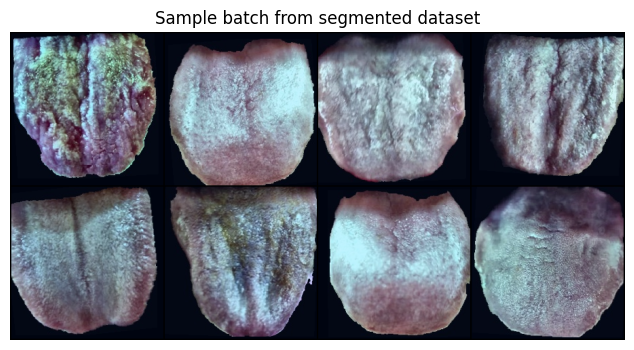

In [ ]:
import matplotlib.pyplot as plt
import torchvision

images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images[:8], nrow=4, normalize=True, scale_each=True)
plt.figure(figsize=(8, 4))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title("Sample batch from segmented dataset")
plt.show()


In [ ]:
import torch
from torch import nn
import timm
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, f1_score
import numpy as np


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = timm.create_model(
    "tf_efficientnet_b0",
    pretrained=True,
    num_classes=2   # 2 classes: diabetes / nondiabetes
)
model = model.to(device)

# Freeze all layers except the final classifier for Phase 1
for name, param in model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False

# Quick check: how many params are trainable now?
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params     = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable_params} / {total_params}")



Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Trainable params: 2562 / 4010110


In [ ]:
criterion = nn.CrossEntropyLoss()


In [ ]:
import torch.optim as optim

# Only train the unfrozen (classifier) parameters
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,          # higher LR, only small head is training
    weight_decay=1e-4
)

In [ ]:
from tqdm import tqdm
import torch

def train_one_epoch_phase1(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in tqdm(loader, desc="Train (phase 1)", leave=False):
        imgs   = imgs.to(device)
        labels = labels.to(device)   # labels are 0/1 as longs (OK for CE)

        optimizer.zero_grad()
        outputs = model(imgs)        # shape [B, 2]
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

        # predictions
        _, preds = outputs.max(1)    # argmax over 2 logits
        correct += preds.eq(labels).sum().item()
        total   += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc


def evaluate_phase1(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs   = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)

            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total   += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc


In [ ]:
EPOCHS_PHASE1 = 15

for epoch in range(1, EPOCHS_PHASE1 + 1):
    print(f"\n[Phase 1] Epoch {epoch}/{EPOCHS_PHASE1}")

    train_loss, train_acc = train_one_epoch_phase1(
        model, train_loader, criterion, optimizer, device
    )

    val_loss, val_acc = evaluate_phase1(
        model, val_loader, criterion, device
    )

    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")



[Phase 1] Epoch 1/15


  Train Loss: 1.2893 | Train Acc: 0.5533
  Val   Loss: 1.2420 | Val   Acc: 0.5795

[Phase 1] Epoch 2/15


  Train Loss: 0.8232 | Train Acc: 0.6720
  Val   Loss: 0.9018 | Val   Acc: 0.6989

[Phase 1] Epoch 3/15


  Train Loss: 0.5914 | Train Acc: 0.7530
  Val   Loss: 0.9219 | Val   Acc: 0.7159

[Phase 1] Epoch 4/15


  Train Loss: 0.5058 | Train Acc: 0.7840
  Val   Loss: 0.7935 | Val   Acc: 0.7102

[Phase 1] Epoch 5/15


  Train Loss: 0.4578 | Train Acc: 0.8137
  Val   Loss: 0.6838 | Val   Acc: 0.7898

[Phase 1] Epoch 6/15


  Train Loss: 0.3975 | Train Acc: 0.8300
  Val   Loss: 0.6450 | Val   Acc: 0.8182

[Phase 1] Epoch 7/15


  Train Loss: 0.3893 | Train Acc: 0.8383
  Val   Loss: 0.6335 | Val   Acc: 0.8125

[Phase 1] Epoch 8/15


  Train Loss: 0.3378 | Train Acc: 0.8603
  Val   Loss: 0.6390 | Val   Acc: 0.8239

[Phase 1] Epoch 9/15


  Train Loss: 0.3341 | Train Acc: 0.8607
  Val   Loss: 0.6932 | Val   Acc: 0.7727

[Phase 1] Epoch 10/15


  Train Loss: 0.2912 | Train Acc: 0.8710
  Val   Loss: 0.6244 | Val   Acc: 0.8295

[Phase 1] Epoch 11/15


  Train Loss: 0.2851 | Train Acc: 0.8800
  Val   Loss: 0.5808 | Val   Acc: 0.8466

[Phase 1] Epoch 12/15


  Train Loss: 0.2553 | Train Acc: 0.8967
  Val   Loss: 0.5797 | Val   Acc: 0.8466

[Phase 1] Epoch 13/15


  Train Loss: 0.2480 | Train Acc: 0.8983
  Val   Loss: 0.5995 | Val   Acc: 0.8580

[Phase 1] Epoch 14/15


  Train Loss: 0.2515 | Train Acc: 0.8937
  Val   Loss: 0.6320 | Val   Acc: 0.8352

[Phase 1] Epoch 15/15


  Train Loss: 0.2545 | Train Acc: 0.8970
  Val   Loss: 0.5566 | Val   Acc: 0.8636


In [ ]:
# ===== PHASE 2: unfreeze entire EfficientNet =====
for name, param in model.named_parameters():
    param.requires_grad = True

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params     = sum(p.numel() for p in model.parameters())
print(f"Trainable params (Phase 2): {trainable_params} / {total_params}")


Trainable params (Phase 2): 4010110 / 4010110


In [ ]:
import torch.optim as optim

# New optimizer for full fine-tuning
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-5,         # small LR for fine-tuning pretrained backbone
    weight_decay=1e-5
)

# LR scheduler: reduce LR if val loss stops improving
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=2,
)


In [ ]:
# def evaluate_with_metrics(model, loader, criterion, device):
#     model.eval()
#     running_loss = 0.0
#     correct = 0
#     total = 0

#     all_probs = []   # predicted probability for positive class (diabetes)
#     all_labels = []  # true labels (0 or 1)

#     with torch.no_grad():
#         for imgs, labels in loader:
#             imgs   = imgs.to(device)
#             labels = labels.to(device)

#             outputs = model(imgs)  # [B, 2] logits
#             loss = criterion(outputs, labels)

#             running_loss += loss.item() * imgs.size(0)
#             total += labels.size(0)

#             # probs for positive class (index 0 = "diabetes" assuming classes = ['nondiabetes','diabetes'])
#             probs = torch.softmax(outputs, dim=1)[:, 0]    # shape [B]

#             # predicted class (0/1) for accuracy / precision / recall
#             preds = torch.argmax(outputs, dim=1)

#             correct += (preds == labels).sum().item()

#             all_probs.append(probs.cpu())
#             all_labels.append(labels.cpu())

#     epoch_loss = running_loss / total
#     epoch_acc  = correct / total

#     # concatenate all batches
#     all_probs = torch.cat(all_probs).numpy()
#     all_labels = torch.cat(all_labels).numpy()

#     # If validation set accidentally has only one class, some metrics will fail → handle gracefully
#     try:
#         auroc = roc_auc_score(all_labels, all_probs)
#         auprc = average_precision_score(all_labels, all_probs)

#         pred_labels = np.where(all_probs >= 0.5, 0, 1)

#         precision = precision_score(all_labels, pred_labels, pos_label=0)
#         recall    = recall_score(all_labels, pred_labels, pos_label=0)
#         f1        = f1_score(all_labels, pred_labels, pos_label=0)

#     except ValueError:
#         auroc = auprc = precision = recall = f1 = np.nan

#     return epoch_loss, epoch_acc, auroc, auprc, precision, recall, f1


def evaluate_with_metrics(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_probs = []   # predicted P(diabetes)
    all_labels = []  # true labels: 0 = diabetes, 1 = nondiabetes

    with torch.no_grad():
        for imgs, labels in loader:
            imgs   = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)  # [B, 2] logits
            loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)
            total        += labels.size(0)

            # probs for "diabetes" (class index 0)
            probs = torch.softmax(outputs, dim=1)[:, 0]    # shape [B]

            # predicted class (0/1) for accuracy
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == labels).sum().item()

            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())

    epoch_loss = running_loss / total
    epoch_acc  = correct / total

    # concatenate all batches
    all_probs  = torch.cat(all_probs).numpy()   # P(diabetes)
    all_labels = torch.cat(all_labels).numpy()  # 0 = diabetes, 1 = nondiabetes

    # Recode labels so that diabetes = 1 (positive), nondiabetes = 0
    y_bin = (all_labels == 0).astype(int)       # 1 = diabetes, 0 = nondiabetes

    try:
        # AUROC/AUPRC now see "1" as positive = diabetes
        auroc = roc_auc_score(y_bin, all_probs)
        auprc = average_precision_score(y_bin, all_probs)

        # threshold at 0.5 → diabetes if prob >= 0.5
        pred_bin = (all_probs >= 0.5).astype(int)  # 1 = diabetes

        precision = precision_score(y_bin, pred_bin)  # pos_label=1 by default
        recall    = recall_score(y_bin, pred_bin)
        f1        = f1_score(y_bin, pred_bin)

    except ValueError:
        auroc = auprc = precision = recall = f1 = np.nan

    return epoch_loss, epoch_acc, auroc, auprc, precision, recall, f1


In [ ]:
EPOCHS_PHASE2 = 15

best_auprc = -1.0   # we'll keep best model based on AUPRC (good for imbalance)
save_path = "/content/drive/MyDrive/TongueImagediabetes/data/best_classifier_finetuned.pth"

for epoch in range(1, EPOCHS_PHASE2 + 1):
    print(f"\n[Phase 2] Epoch {epoch}/{EPOCHS_PHASE2}")

    # same train function as Phase 1 (it just does forward/backward/step)
    train_loss, train_acc = train_one_epoch_phase1(
        model, train_loader, criterion, optimizer, device
    )

    # now use the richer evaluator with AUROC/AUPRC/etc.
    (val_loss, val_acc,
     auroc, auprc,
     precision, recall, f1) = evaluate_with_metrics(
        model, val_loader, criterion, device
    )

    # update LR scheduler with validation loss
    scheduler.step(val_loss)

    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"  AUROC: {auroc:.4f} | AUPRC: {auprc:.4f}")
    print(f"  Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

    # Save best model by AUPRC (recommended for imbalanced medical data)
    if auprc > best_auprc:
        best_auprc = auprc
        torch.save(model.state_dict(), save_path)
        print(f"  ✓ Saved new best model (by AUPRC) to: {save_path}")



[Phase 2] Epoch 1/15


  Train Loss: 0.1908 | Train Acc: 0.9223
  Val   Loss: 0.5029 | Val Acc: 0.8750
  AUROC: 0.9202 | AUPRC: 0.8960
  Precision: 0.8235 | Recall: 0.9091 | F1: 0.8642
  ✓ Saved new best model (by AUPRC) to: /content/drive/MyDrive/TongueImagediabetes/data/best_classifier_finetuned.pth

[Phase 2] Epoch 2/15


  Train Loss: 0.1367 | Train Acc: 0.9480
  Val   Loss: 0.4471 | Val Acc: 0.8693
  AUROC: 0.9385 | AUPRC: 0.9233
  Precision: 0.8068 | Recall: 0.9221 | F1: 0.8606
  ✓ Saved new best model (by AUPRC) to: /content/drive/MyDrive/TongueImagediabetes/data/best_classifier_finetuned.pth

[Phase 2] Epoch 3/15


  Train Loss: 0.0998 | Train Acc: 0.9603
  Val   Loss: 0.4197 | Val Acc: 0.9034
  AUROC: 0.9454 | AUPRC: 0.9261
  Precision: 0.8571 | Recall: 0.9351 | F1: 0.8944
  ✓ Saved new best model (by AUPRC) to: /content/drive/MyDrive/TongueImagediabetes/data/best_classifier_finetuned.pth

[Phase 2] Epoch 4/15


  Train Loss: 0.0702 | Train Acc: 0.9750
  Val   Loss: 0.4131 | Val Acc: 0.9034
  AUROC: 0.9545 | AUPRC: 0.9348
  Precision: 0.8409 | Recall: 0.9610 | F1: 0.8970
  ✓ Saved new best model (by AUPRC) to: /content/drive/MyDrive/TongueImagediabetes/data/best_classifier_finetuned.pth

[Phase 2] Epoch 5/15


  Train Loss: 0.0613 | Train Acc: 0.9787
  Val   Loss: 0.3976 | Val Acc: 0.9091
  AUROC: 0.9570 | AUPRC: 0.9431
  Precision: 0.8588 | Recall: 0.9481 | F1: 0.9012
  ✓ Saved new best model (by AUPRC) to: /content/drive/MyDrive/TongueImagediabetes/data/best_classifier_finetuned.pth

[Phase 2] Epoch 6/15


  Train Loss: 0.0463 | Train Acc: 0.9870
  Val   Loss: 0.3519 | Val Acc: 0.9375
  AUROC: 0.9580 | AUPRC: 0.9412
  Precision: 0.9125 | Recall: 0.9481 | F1: 0.9299

[Phase 2] Epoch 7/15


  Train Loss: 0.0373 | Train Acc: 0.9863
  Val   Loss: 0.3784 | Val Acc: 0.9091
  AUROC: 0.9597 | AUPRC: 0.9421
  Precision: 0.8588 | Recall: 0.9481 | F1: 0.9012

[Phase 2] Epoch 8/15


  Train Loss: 0.0287 | Train Acc: 0.9923
  Val   Loss: 0.3620 | Val Acc: 0.9375
  AUROC: 0.9629 | AUPRC: 0.9487
  Precision: 0.9024 | Recall: 0.9610 | F1: 0.9308
  ✓ Saved new best model (by AUPRC) to: /content/drive/MyDrive/TongueImagediabetes/data/best_classifier_finetuned.pth

[Phase 2] Epoch 9/15


  Train Loss: 0.0368 | Train Acc: 0.9853
  Val   Loss: 0.3403 | Val Acc: 0.9318
  AUROC: 0.9655 | AUPRC: 0.9506
  Precision: 0.9012 | Recall: 0.9481 | F1: 0.9241
  ✓ Saved new best model (by AUPRC) to: /content/drive/MyDrive/TongueImagediabetes/data/best_classifier_finetuned.pth

[Phase 2] Epoch 10/15


  Train Loss: 0.0206 | Train Acc: 0.9937
  Val   Loss: 0.3277 | Val Acc: 0.9375
  AUROC: 0.9692 | AUPRC: 0.9526
  Precision: 0.9024 | Recall: 0.9610 | F1: 0.9308
  ✓ Saved new best model (by AUPRC) to: /content/drive/MyDrive/TongueImagediabetes/data/best_classifier_finetuned.pth

[Phase 2] Epoch 11/15


  Train Loss: 0.0196 | Train Acc: 0.9930
  Val   Loss: 0.3568 | Val Acc: 0.9375
  AUROC: 0.9680 | AUPRC: 0.9471
  Precision: 0.9024 | Recall: 0.9610 | F1: 0.9308

[Phase 2] Epoch 12/15


  Train Loss: 0.0156 | Train Acc: 0.9953
  Val   Loss: 0.3451 | Val Acc: 0.9432
  AUROC: 0.9713 | AUPRC: 0.9563
  Precision: 0.9036 | Recall: 0.9740 | F1: 0.9375
  ✓ Saved new best model (by AUPRC) to: /content/drive/MyDrive/TongueImagediabetes/data/best_classifier_finetuned.pth

[Phase 2] Epoch 13/15


  Train Loss: 0.0189 | Train Acc: 0.9947
  Val   Loss: 0.3259 | Val Acc: 0.9489
  AUROC: 0.9759 | AUPRC: 0.9601
  Precision: 0.9146 | Recall: 0.9740 | F1: 0.9434
  ✓ Saved new best model (by AUPRC) to: /content/drive/MyDrive/TongueImagediabetes/data/best_classifier_finetuned.pth

[Phase 2] Epoch 14/15


  Train Loss: 0.0175 | Train Acc: 0.9947
  Val   Loss: 0.3253 | Val Acc: 0.9432
  AUROC: 0.9725 | AUPRC: 0.9558
  Precision: 0.9136 | Recall: 0.9610 | F1: 0.9367

[Phase 2] Epoch 15/15


  Train Loss: 0.0154 | Train Acc: 0.9950
  Val   Loss: 0.2777 | Val Acc: 0.9489
  AUROC: 0.9780 | AUPRC: 0.9649
  Precision: 0.9250 | Recall: 0.9610 | F1: 0.9427
  ✓ Saved new best model (by AUPRC) to: /content/drive/MyDrive/TongueImagediabetes/data/best_classifier_finetuned.pth


In [ ]:
import torch

save_path = "/content/drive/MyDrive/TongueImagediabetes/data/best_classifier_finetuned.pth"

model.load_state_dict(torch.load(save_path, map_location=device))
model = model.to(device)
model.eval()
print("Loaded best fine-tuned model.")


Loaded best fine-tuned model.


In [ ]:
test_loss, test_acc, auroc, auprc, precision, recall, f1 = evaluate_with_metrics(
    model, test_loader, criterion, device
)

print("\n=== TEST RESULTS ===")
print(f"Loss:      {test_loss:.4f}")
print(f"Accuracy:  {test_acc:.4f}")
print(f"AUROC:     {auroc:.4f}")
print(f"AUPRC:     {auprc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1:        {f1:.4f}")



=== TEST RESULTS ===
Loss:      0.3583
Accuracy:  0.9245
AUROC:     0.9715
AUPRC:     0.9795
Precision: 1.0000
Recall:    0.8462
F1:        0.9167


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
def get_preds_and_labels(model, loader, device):
    model.eval()
    all_labels = []
    all_preds  = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs   = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)          # [B, 2]
            preds   = outputs.argmax(1)    # class index 0/1

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


<Figure size 400x400 with 0 Axes>

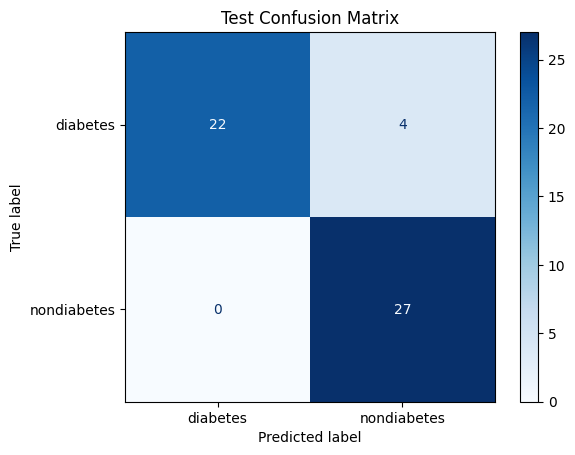

Confusion matrix (rows = true, cols = pred):
[[22  4]
 [ 0 27]]


In [ ]:
# get predictions
y_true, y_pred = get_preds_and_labels(model, test_loader, device)

# build confusion matrix
#cm = confusion_matrix(y_true, y_pred)

class_names = ["diabetes", "nondiabetes"]

# build confusion matrix
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)

plt.figure(figsize=(4,4))
disp.plot(values_format='d', cmap='Blues')
plt.title("Test Confusion Matrix")
plt.show()

print("Confusion matrix (rows = true, cols = pred):")
print(cm)


In [ ]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])

def tensor_to_numpy_img(t):
    """
    t: [3,H,W] tensor (normalized) -> [H,W,3] uint8 image
    """
    t = t.detach().cpu().numpy()
    t = (t * IMAGENET_STD[:, None, None]) + IMAGENET_MEAN[:, None, None]
    t = np.clip(t, 0, 1)
    t = np.transpose(t, (1, 2, 0))  # HWC
    t = (t * 255).astype(np.uint8)
    return t


In [ ]:
import torch.nn.functional as F
import cv2

# storage for forward feature maps and backward gradients
gradcam_features = {}
gradcam_grads = {}

# choose target layer for Grad-CAM: last conv feature layer
target_layer = model.conv_head  # works for tf_efficientnet_b0 in timm

def fwd_hook(module, inp, out):
    gradcam_features['value'] = out

def bwd_hook(module, grad_in, grad_out):
    gradcam_grads['value'] = grad_out[0]

# register hooks (do this once)
_ = target_layer.register_forward_hook(fwd_hook)
_ = target_layer.register_backward_hook(bwd_hook)


In [ ]:
def gradcam_for_image(model, img_tensor, device, target_class=None):
    """
    img_tensor: [1,3,224,224]
    target_class: index (0 or 1). If None → uses predicted class.
    returns: heatmap (H,W) in [0,1]
    """
    model.eval()
    gradcam_features.clear()
    gradcam_grads.clear()

    img_tensor = img_tensor.to(device)

    # forward
    outputs = model(img_tensor)  # [1,2]
    if target_class is None:
        target_class = outputs.argmax(1).item()

    score = outputs[0, target_class]

    # backward
    model.zero_grad()
    score.backward()

    # get feature maps and gradients
    fmap = gradcam_features['value'][0]   # [C,H,W]
    grads = gradcam_grads['value'][0]     # [C,H,W]

    # global-average-pool the gradients to get weights
    weights = grads.mean(dim=(1, 2))      # [C]

    # weighted sum of feature maps
    cam = torch.zeros(fmap.shape[1:], dtype=torch.float32, device=device)  # [H,W]
    for w, f in zip(weights, fmap):
        cam += w * f

    cam = F.relu(cam)                     # negative values → 0
    cam = cam - cam.min()
    if cam.max() > 0:
        cam = cam / cam.max()
    cam = cam.detach().cpu().numpy()      # [H,W] in [0,1]

    # upsample to 224x224 if needed
    cam = cv2.resize(cam, (img_tensor.shape[3], img_tensor.shape[2]))
    return cam


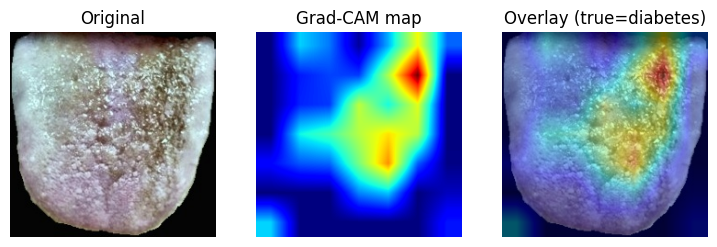

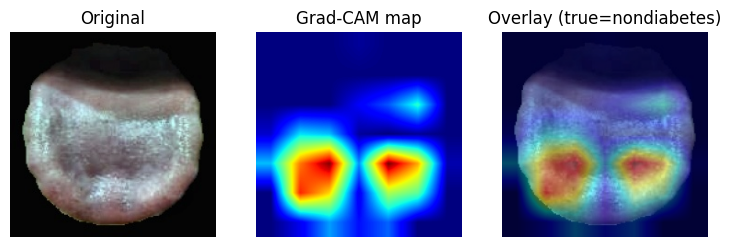

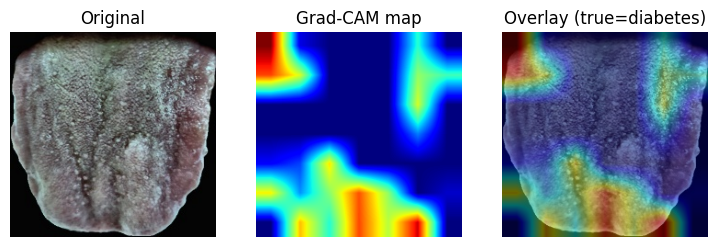

In [ ]:
import matplotlib.pyplot as plt

def show_gradcam_on_sample(model, dataset, index, device, class_names=None):
    """
    dataset: ImageFolder or Subset with (img, label)
    index: index into dataset
    """
    img, label = dataset[index]  # img: [3,224,224] normalized tensor
    img_np = tensor_to_numpy_img(img)  # original-looking image

    # add batch dimension
    img_batch = img.unsqueeze(0)

    # get Grad-CAM heatmap
    cam = gradcam_for_image(model, img_batch, device)  # [H,W] in [0,1]

    # create overlay
    heatmap = cv2.applyColorMap((cam * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = (0.4 * heatmap + 0.6 * img_np).astype(np.uint8)

    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1)
    plt.imshow(img_np); plt.axis('off'); plt.title("Original")

    plt.subplot(1,3,2)
    plt.imshow(cam, cmap='jet'); plt.axis('off'); plt.title("Grad-CAM map")

    plt.subplot(1,3,3)
    plt.imshow(overlay); plt.axis('off')
    title = f"Overlay (true={label})"
    if class_names is not None:
        title = f"Overlay (true={class_names[label]})"
    plt.title(title)
    plt.show()

# example: show Grad-CAM on 3 random test samples
import random
class_names = test_ds.classes

for _ in range(3):
    idx = random.randint(0, len(test_ds) - 1)
    show_gradcam_on_sample(model, test_ds, idx, device, class_names)


In [ ]:
# Datasets WITHOUT augmentation (for embedding extraction)
train_embed_ds = TongueDataset(train_dir, transform=val_tfms)  # no aug
val_embed_ds   = TongueDataset(val_dir,   transform=val_tfms)
test_embed_ds  = TongueDataset(test_dir,  transform=val_tfms)

from torch.utils.data import DataLoader

embed_batch_size = 64

train_embed_loader = DataLoader(train_embed_ds, batch_size=embed_batch_size,
                                shuffle=False, num_workers=2)
val_embed_loader   = DataLoader(val_embed_ds,   batch_size=embed_batch_size,
                                shuffle=False, num_workers=2)
test_embed_loader  = DataLoader(test_embed_ds,  batch_size=embed_batch_size,
                                shuffle=False, num_workers=2)


In [ ]:
import torch
import numpy as np

def extract_embeddings(model, loader, device):
    """
    Returns:
        feats:  [N, D] numpy array of feature embeddings
        labels: [N]   numpy array of class indices
    """
    model.eval()
    all_feats = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)

            # timm EfficientNet: forward_features -> feature map
            feat_map = model.forward_features(imgs)          # [B, C, H, W] or [B, C]

            # global pooling to get [B, C]
            pooled = model.global_pool(feat_map)             # often [B, C, 1, 1] or [B, C]
            if pooled.ndim == 4:
                pooled = pooled[:, :, 0, 0]                  # [B, C]

            all_feats.append(pooled.cpu())
            all_labels.append(labels)

    feats  = torch.cat(all_feats, dim=0).numpy()
    labels = torch.cat(all_labels, dim=0).numpy()
    return feats, labels


In [ ]:
train_feats, train_labels = extract_embeddings(model, train_embed_loader, device)
val_feats,   val_labels   = extract_embeddings(model, val_embed_loader,   device)
test_feats,  test_labels  = extract_embeddings(model, test_embed_loader,  device)

print("Train embeddings:", train_feats.shape, "labels:", train_labels.shape)
print("Val embeddings  :", val_feats.shape,   "labels:", val_labels.shape)
print("Test embeddings :", test_feats.shape,  "labels:", test_labels.shape)


Train embeddings: (595, 1280) labels: (595,)
Val embeddings  : (176, 1280) labels: (176,)
Test embeddings : (53, 1280) labels: (53,)


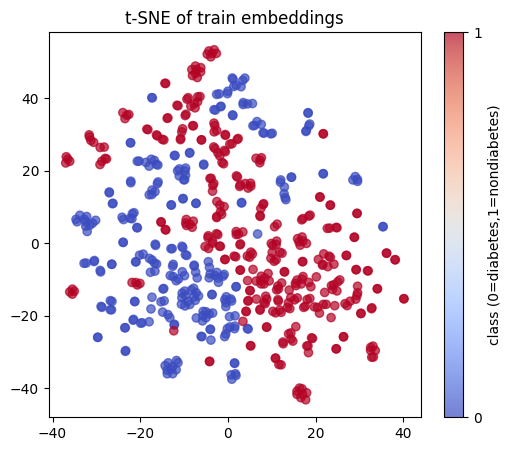

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = train_feats
y = train_labels  # 0 = diabetes, 1 = nondiabetes

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(6,5))
scatter = plt.scatter(X_2d[:,0], X_2d[:,1], c=y, cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, ticks=[0,1], label="class (0=diabetes,1=nondiabetes)")
plt.title("t-SNE of train embeddings")
plt.show()


In [ ]:
import numpy as np

np.savez("/content/drive/MyDrive/TongueImagediabetes/data/embeddings_train_val_test.npz",
         train_feats=train_feats,
         train_labels=train_labels,
         val_feats=val_feats,
         val_labels=val_labels,
         test_feats=test_feats,
         test_labels=test_labels)
